In [ ]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional


Sunspot

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler


In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/Sunspots.csv \
    -O /tmp/sunspots.csv

--2023-10-12 00:39:05--  https://storage.googleapis.com/learning-datasets/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.120.207, 142.251.161.207, 74.125.126.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.120.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2023-10-12 00:39:05 (51.5 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



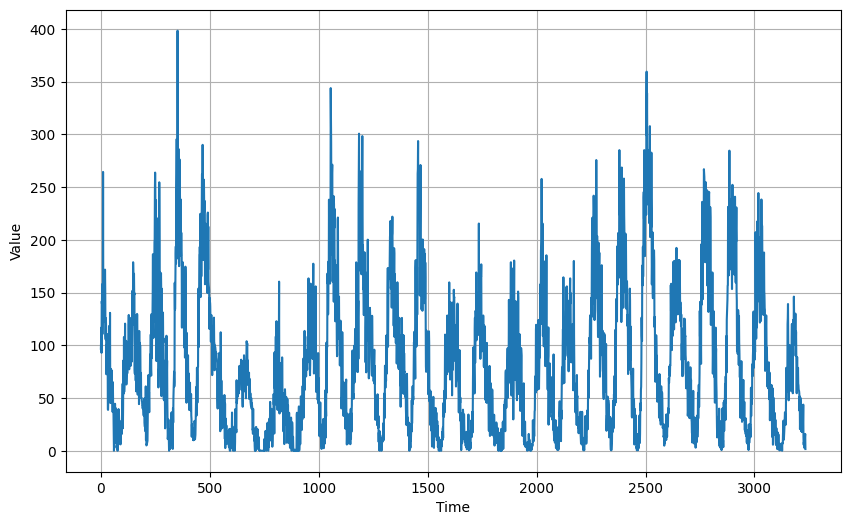

In [ ]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
scaler = MinMaxScaler()
series = scaler.fit_transform(series.reshape(-1, 1))
print(series)

[[0.24284279]
 [0.26192868]
 [0.29306881]
 ...
 [0.03314917]
 [0.03992968]
 [0.00401808]]


In [ ]:
series = series.flatten()

In [ ]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [ ]:
def load_image_test(image, label):
  scaled_image = image / 255.0
  return scaled_image, label

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda window: (window[:-1], window[1:]))
  ds = ds.batch(batch_size).prefetch(1)
  return ds


In [ ]:
tf.random.set_seed(0)
np.random.seed(0)

train_set = windowed_dataset(x_train, window_size=60, batch_size=64, shuffle_buffer=shuffle_buffer_size)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Bidirectional
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
checkpoint = ModelCheckpoint(filepath='model.h5', monitor='mae', verbose=0, save_best_only=True)

In [ ]:
clear_session()
tf.random.set_seed(0)
np.random.seed(0)

train_set = windowed_dataset(x_train, window_size=60, batch_size=64, shuffle_buffer=shuffle_buffer_size)

In [ ]:
# (64, 60, 7)

In [ ]:
list(train_set.take(1))

[(<tf.Tensor: shape=(64, 60, 1), dtype=float64, numpy=
  array([[[0.18407835],
          [0.14239076],
          [0.09718734],
          ...,
          [0.5642893 ],
          [0.41511803],
          [0.53566047]],
  
         [[0.20165746],
          [0.20015068],
          [0.19663486],
          ...,
          [0.10045203],
          [0.11300854],
          [0.10472125]],
  
         [[0.10748368],
          [0.10045203],
          [0.10873933],
          ...,
          [0.62280261],
          [0.66223004],
          [0.61978905]],
  
         ...,
  
         [[0.09969864],
          [0.04193872],
          [0.05022602],
          ...,
          [0.04721246],
          [0.00803616],
          [0.00301356]],
  
         [[0.06253139],
          [0.0492215 ],
          [0.01155198],
          ...,
          [0.44801607],
          [0.54269211],
          [0.60647916]],
  
         [[0.01682572],
          [0.01808137],
          [0.0208438 ],
          ...,
          [0.63912607],
  

In [ ]:
model = Sequential([
      LSTM(64, return_sequences=True, input_shape=[None, 7]),
      Dense(32, activation='relu'),
      Dense(7)
])
# optim = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=['mae'])
# history = model.fit(train_set, epochs=100, callbacks=[checkpoint])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 64)          18432     
                                                                 
 dense (Dense)               (None, None, 32)          2080      
                                                                 
 dense_1 (Dense)             (None, None, 7)           231       
                                                                 
Total params: 20743 (81.03 KB)
Trainable params: 20743 (81.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model = Sequential([
      LSTM(64, return_sequences=True),
      LSTM(64, return_sequences=True),
      Dense(32, activation='relu'),
      Dense(16, activation='relu'),
      Dense(1)
])
# optim = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[checkpoint])

Epoch 1/100
46/46 [==============================] - 17s 19ms/step - loss: 0.0063 - mae: 0.0785


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
46/46 [==============================] - 1s 18ms/step - loss: 0.0030 - mae: 0.0547
Epoch 3/100
46/46 [==============================] - 1s 18ms/step - loss: 0.0026 - mae: 0.0518
Epoch 4/100
46/46 [==============================] - 1s 18ms/step - loss: 0.0025 - mae: 0.0502
Epoch 5/100
46/46 [==============================] - 1s 18ms/step - loss: 0.0023 - mae: 0.0492
Epoch 6/100
46/46 [==============================] - 1s 24ms/step - loss: 0.0022 - mae: 0.0483
Epoch 7/100
46/46 [==============================] - 2s 31ms/step - loss: 0.0022 - mae: 0.0472
Epoch 8/100
46/46 [==============================] - 1s 18ms/step - loss: 0.0021 - mae: 0.0465
Epoch 9/100
46/46 [==============================] - 1s 17ms/step - loss: 0.0021 - mae: 0.0460
Epoch 10/100
46/46 [==============================] - 1s 18ms/step - loss: 0.0020 - mae: 0.0457
Epoch 11/100
46/46 [==============================] - 1s 19ms/step - loss: 0.0020 - mae: 0.0452
Epoch 12/100
46/46 [============================

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

101/101 [==============================] - 2s 8ms/step


0.03916856

In [ ]:
model = Sequential([
      Bidirectional(LSTM(64, return_sequences=True)),
      Bidirectional(LSTM(64, return_sequences=True)),
      Dense(32, activation='relu'),
      Dense(16, activation='relu'),
      Dense(1)
])
# optim = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[checkpoint])

Epoch 1/100
46/46 [==============================] - 11s 22ms/step - loss: 0.0054 - mae: 0.0696
Epoch 2/100
46/46 [==============================] - 1s 23ms/step - loss: 0.0018 - mae: 0.0411
Epoch 3/100
46/46 [==============================] - 2s 31ms/step - loss: 0.0014 - mae: 0.0370
Epoch 4/100
46/46 [==============================] - 2s 38ms/step - loss: 0.0012 - mae: 0.0343
Epoch 5/100
46/46 [==============================] - 1s 23ms/step - loss: 0.0010 - mae: 0.0319
Epoch 6/100
46/46 [==============================] - 1s 22ms/step - loss: 9.7732e-04 - mae: 0.0316
Epoch 7/100
46/46 [==============================] - 1s 22ms/step - loss: 8.6474e-04 - mae: 0.0297
Epoch 8/100
46/46 [==============================] - 1s 21ms/step - loss: 8.8690e-04 - mae: 0.0299
Epoch 9/100
46/46 [==============================] - 1s 21ms/step - loss: 9.6398e-04 - mae: 0.0314
Epoch 10/100
46/46 [==============================] - 1s 23ms/step - loss: 7.1583e-04 - mae: 0.0271
Epoch 11/100
46/46 [========

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.03916856

In [ ]:
clear_session()
tf.random.set_seed(0)
np.random.seed(0)

train_set = windowed_dataset(x_train, window_size=60, batch_size=64, shuffle_buffer=shuffle_buffer_size)
model = Sequential([
                    Conv1D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=[None, 1]),
                    LSTM(64, return_sequences=True),
                    LSTM(64, return_sequences=True),
                    Dense(32, activation='relu'),
                    Dense(16, activation='relu'),
                    Dense(1)
])
# optim = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[checkpoint])

Epoch 1/100
46/46 [==============================] - 11s 31ms/step - loss: 0.0079 - mae: 0.0877
Epoch 2/100
46/46 [==============================] - 2s 27ms/step - loss: 0.0023 - mae: 0.0469
Epoch 3/100
46/46 [==============================] - 1s 17ms/step - loss: 0.0012 - mae: 0.0345
Epoch 4/100
46/46 [==============================] - 1s 17ms/step - loss: 8.0771e-04 - mae: 0.0272
Epoch 5/100
46/46 [==============================] - 1s 18ms/step - loss: 6.4226e-04 - mae: 0.0241
Epoch 6/100
46/46 [==============================] - 1s 19ms/step - loss: 4.9837e-04 - mae: 0.0213
Epoch 7/100
46/46 [==============================] - 1s 18ms/step - loss: 4.4377e-04 - mae: 0.0203
Epoch 8/100
46/46 [==============================] - 1s 17ms/step - loss: 2.4834e-04 - mae: 0.0137
Epoch 9/100
46/46 [==============================] - 1s 18ms/step - loss: 1.8404e-04 - mae: 0.0110
Epoch 10/100
46/46 [==============================] - 1s 24ms/step - loss: 1.5799e-04 - mae: 0.0103
Epoch 11/100
46/46 [

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

101/101 [==============================] - 1s 7ms/step


0.03717372

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.03717372

Conv1D

In [ ]:
clear_session()
tf.random.set_seed(0)
np.random.seed(0)

train_set = windowed_dataset(x_train, window_size=60, batch_size=64, shuffle_buffer=shuffle_buffer_size)
model = Sequential([
      Conv1D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=[None, 1]),
      LSTM(64, return_sequences=True),
      LSTM(64, return_sequences=True),
      Dense(32, activation='relu'),
      Dense(16, activation='relu'),
      Dense(1)
])
# optim = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[checkpoint])

Epoch 1/100
46/46 [==============================] - 6s 30ms/step - loss: 0.0069 - mae: 0.0823
Epoch 2/100
46/46 [==============================] - 1s 22ms/step - loss: 0.0021 - mae: 0.0447
Epoch 3/100
46/46 [==============================] - 1s 17ms/step - loss: 0.0012 - mae: 0.0340
Epoch 4/100
46/46 [==============================] - 1s 17ms/step - loss: 8.5056e-04 - mae: 0.0281
Epoch 5/100
46/46 [==============================] - 1s 17ms/step - loss: 6.2878e-04 - mae: 0.0246
Epoch 6/100
46/46 [==============================] - 1s 16ms/step - loss: 4.5727e-04 - mae: 0.0212
Epoch 7/100
46/46 [==============================] - 1s 17ms/step - loss: 3.1552e-04 - mae: 0.0175
Epoch 8/100
46/46 [==============================] - 1s 17ms/step - loss: 1.8983e-04 - mae: 0.0127
Epoch 9/100
46/46 [==============================] - 1s 16ms/step - loss: 1.3870e-04 - mae: 0.0105
Epoch 10/100
46/46 [==============================] - 1s 17ms/step - loss: 9.7180e-05 - mae: 0.0078
Epoch 11/100
46/46 [=

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

101/101 [==============================] - 2s 11ms/step


0.037175447

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 64)          384       
                                                                 
 lstm (LSTM)                 (None, None, 64)          33024     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          33024     
                                                                 
 dense (Dense)               (None, None, 32)          2080      
                                                                 
 dense_1 (Dense)             (None, None, 16)          528       
                                                                 
 dense_2 (Dense)             (None, None, 1)           17        
                                                                 
Total params: 69057 (269.75 KB)
Trainable params: 69057 

Forcast

In [ ]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1 , drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

101/101 [==============================] - 1s 8ms/step


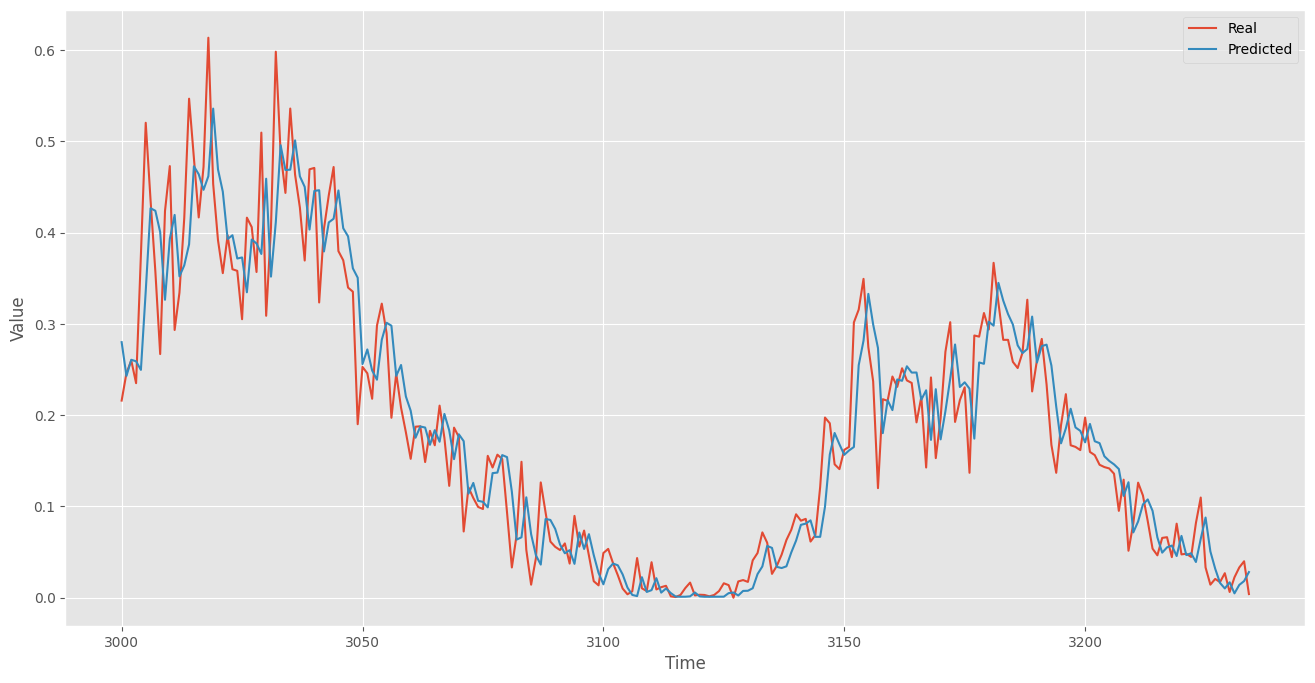

In [ ]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(16, 8))
    plot_series(time_valid, x_valid)
    plot_series(time_valid, rnn_forecast)
    labels = ['Real', 'Predicted']
    plt.legend(labels)
    plt.show()

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.037175447